<a href="https://colab.research.google.com/github/romanbash/DTSA-5510--final-project/blob/main/Anomaly_Detection_In_HTTP_Traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DTSA-5510- Final Project**
# **Anomaly Detection In HTTP Traffic**

Github :

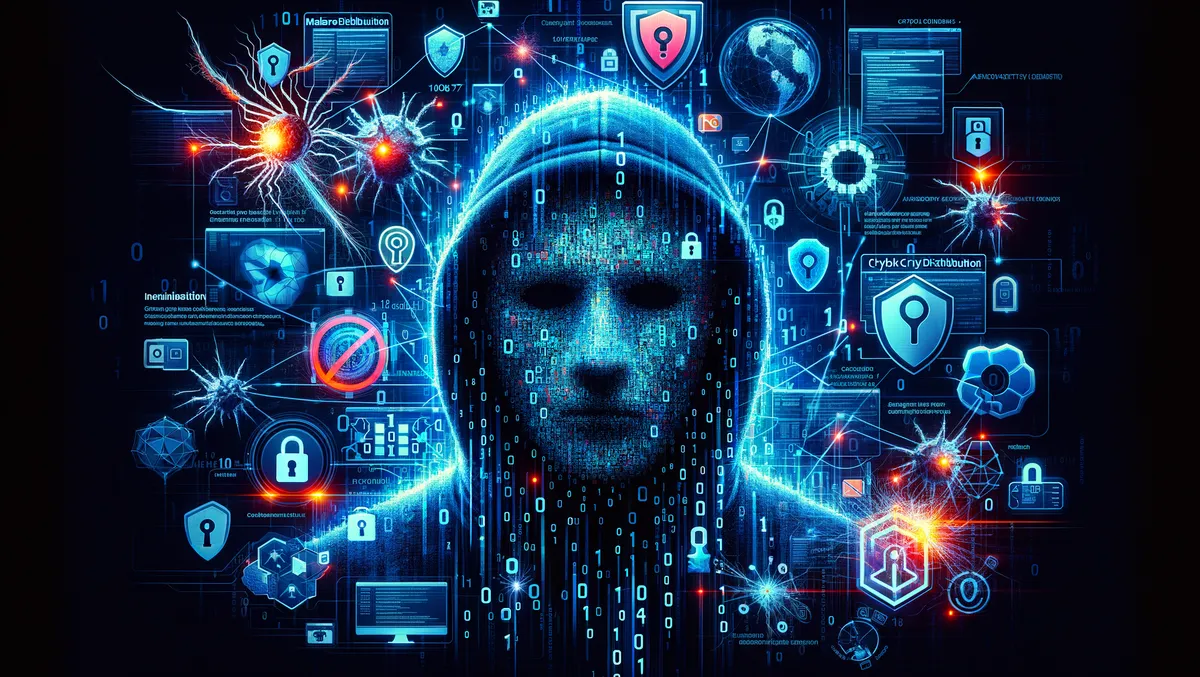

# Topic

The main objective of this project is to classify Cyber-attacks by investigating HTTP traffic with anomaly detection techniques. Unlike many other projects and intrusion prevention systems that rely on rule-based or supervised learning algorithms, we focus on identifying and categorizing these attacks based on their unique patterns.
In this project, we take the raw data as parsed PCAP and use unsupervised models and statistical anomaly detection techniques to classify cyber-attacks from benign data sessions. We will use the Isolation Forest algorithm, PCA, and TSNE for our investigation during the project.

In [1]:
!pip install zat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.2/234.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import json
import zat
from zat.log_to_dataframe import LogToDataFrame
from matplotlib import pyplot as plt
from zat.dataframe_to_matrix import DataFrameToMatrix
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns

In [3]:
# We mount our google drive, where we store our data

from google.colab import drive
drive.mount('/content/drive')


#This is the path for the data in the goggle drive. If you would like to run it
#change this line to the path in your drive.

http_log = '/content/drive/MyDrive/DTSA 5510/final project/Data/http_small.log'

Mounted at /content/drive


# Data

###Context - taken from Brim Data Github
This project aims to develop an anomaly detection system for HTTP logs, leveraging advanced techniques to identify irregularities in web traffic. HTTP logs provide invaluable insights into the interactions between clients (such as web browsers) and servers, making them a crucial resource for monitoring network security, performance, and user behavior. By detecting anomalies in these logs, we can identify potential security threats, performance bottlenecks, and other irregular activities.

### What is HTTP?

Hypertext Transfer Protocol (HTTP) is the foundation of data communication on the World Wide Web. It is an application layer protocol designed for transmitting hypermedia documents, such as HTML. Here are some key aspects of HTTP:

**Request-Response Model**: HTTP operates based on a simple request-response model. A client sends an HTTP request to a server, which then processes the request and returns an appropriate HTTP response.

**Stateless Protocol**: Each HTTP request is independent, meaning the server does not retain any information about previous requests from the same client. This stateless nature simplifies the design of web applications but necessitates additional mechanisms for maintaining state, such as cookies and sessions.

**Methods**: HTTP defines several methods (e.g., GET, POST, PUT, DELETE) that specify the desired action to be performed on the identified resource.

**Status Codes**: HTTP responses include status codes (e.g., 200 OK, 404 Not Found, 500 Internal Server Error) that indicate the outcome of the request.

### Number of features/columns: 144593 rows and 29 columns.

### Size: 15.1 Mb



###Attribute Information

1) **ts** (time): Timestamp for when request happened

2) **uid** & id: Underlying connection info

3) **method** (string): Verb used in HTTP request (GET, POST, etc.)

4) **host** (string): Value of HOST header

5) **uri** (string): URI used in request

6) **referrer** (string): Value of referrer header

7) **user_agent** (string): Value of User-Agent header from client

8) **status_code** (count): Status code returned by server

9) **info_msg** (string): Last seen 1xx info reply message from server

10) **username** (string): Username if basic-auth performed for request

11) **password** (string): Password if basic-auth performed for request

12) **proxied** (table): All headers indicative of proxied request

13) **orig_fuids** (vector): Ordered vector of file unique IDs

14) **orig_filenames** (vector): Ordered vector of filenames from client

15) **resp_fuids** (vector): Ordered vector of file unique IDs

16) **resp_filenames** (vector): Ordered vector of filenames from server

17) **resp_mime_types** (vector): Ordered vector of mime types

18) **client_header_names** (vector): Vector of HTTP header names sent by client

19) **server_header_names** (vector): Vector of HTTP header names sent by server

20) **cookie_vars** (vector): Variable names extracted from all cookies

21) **uri_vars** (vector): Variable names from URI


**data project URL**: https://github.com/brimdata/zed-sample-data

**Download data**: https://github.com/brimdata/zed-sample-data/blob/main/zeek-default/http.log.gz



In [4]:
# Create a Pandas dataframe from a Zeek log
log_to_df = LogToDataFrame()
zeek_df = log_to_df.create_dataframe(http_log)

# Print out the head of the dataframe
zeek_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144593 entries, 2018-03-24 17:15:20.609735936 to 2018-03-24 17:33:31.862947072
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   uid                144593 non-null  object  
 1   id.orig_h          144593 non-null  category
 2   id.orig_p          144593 non-null  UInt16  
 3   id.resp_h          144593 non-null  category
 4   id.resp_p          144593 non-null  UInt16  
 5   trans_depth        144593 non-null  UInt64  
 6   method             143196 non-null  category
 7   host               141884 non-null  category
 8   uri                143196 non-null  category
 9   referrer           122345 non-null  category
 10  version            142240 non-null  category
 11  user_agent         142884 non-null  category
 12  origin             76 non-null      category
 13  request_body_len   144590 non-null  UInt64  
 14  response_body_len  144590 non-

The columns of our data are:

In [5]:
zeek_df.columns

Index(['uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'trans_depth', 'method', 'host', 'uri', 'referrer', 'version',
       'user_agent', 'origin', 'request_body_len', 'response_body_len',
       'status_code', 'status_msg', 'info_code', 'info_msg', 'tags',
       'username', 'password', 'proxied', 'orig_fuids', 'orig_filenames',
       'orig_mime_types', 'resp_fuids', 'resp_filenames', 'resp_mime_types'],
      dtype='object')

# Data Cleaning

Not all of the columns are relevant to our task. The uid column is just a random string with no data behind it because it is a session identification. The id.orig_h and id.resp_h are just ips. The username and password don't carry any data, and the status message and info_msg carry the same data as the status_code and info_code—numerical values.

In [6]:
# drop columns

zeek_df = zeek_df.drop(columns=['uid', 'id.orig_h', 'id.resp_h'])


Let's check if we have duplicate rows.

In [7]:
#check for duplicates
zeek_df.duplicated().sum()

0

So, we do have duplicate rows. Let's print an example of such a row and then delete the duplicates.

In [8]:
# Get a sample of duplicate rows
duplicate_rows = zeek_df[zeek_df.duplicated()]
print(duplicate_rows.head())

# Drop all duplicate rows
zeek_df.drop_duplicates(inplace=True)


Empty DataFrame
Columns: [id.orig_p, id.resp_p, trans_depth, method, host, uri, referrer, version, user_agent, origin, request_body_len, response_body_len, status_code, status_msg, info_code, info_msg, tags, username, password, proxied, orig_fuids, orig_filenames, orig_mime_types, resp_fuids, resp_filenames, resp_mime_types]
Index: []

[0 rows x 26 columns]


Now, let's check for missing data and try to explain it.

In [9]:
#check for missing data
missing_data = zeek_df.isnull().sum()
# Print the number of missing values in each column
print(missing_data)

id.orig_p                 0
id.resp_p                 0
trans_depth               0
method                 1397
host                   2709
uri                    1397
referrer              22248
version                2353
user_agent             1709
origin               144517
request_body_len          3
response_body_len         3
status_code            2353
status_msg             2353
info_code            144574
info_msg             144574
tags                      3
username             139734
password             144593
proxied              144569
orig_fuids           136411
orig_filenames       144593
orig_mime_types      136431
resp_fuids             5069
resp_filenames       144572
resp_mime_types        5274
dtype: int64


All the columns with the missing data make sense. We don't have missing IPs or ports. The other missing data could be part of our anomaly detection models, so we don't need to delete these rows or impute these cells.

Next, let's take a look at the numerical columns to see that everything makes sense. The first column is the status code.
we can see from [here](https://https://en.wikipedia.org/wiki/List_of_HTTP_status_codes) that the format of the status codes is 1XX-5XX. So the data makes sense.

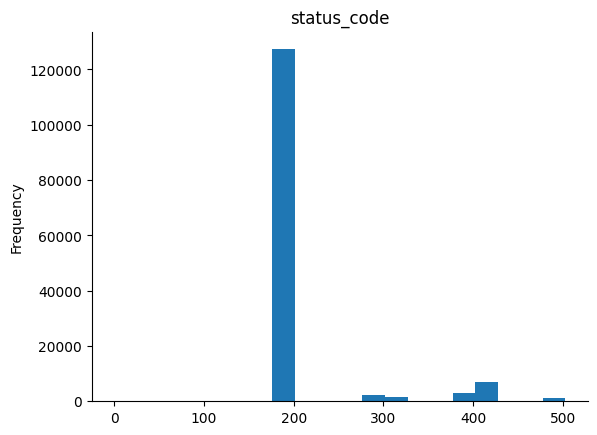

In [10]:

zeek_df['status_code'].plot(kind='hist', bins=20, title='status_code')
plt.gca().spines[['top', 'right',]].set_visible(False)

We can see that the mean body length is 10436 bytes (10 kB), but the standard development is very large. The biggest session is more than 274 Mbytes—a very large number that is definitely an anomaly.

count          144590.0
mean       10436.360336
std      1054640.916041
min                 0.0
25%                49.0
50%                50.0
75%                52.0
max         274063360.0
Name: response_body_len, dtype: Float64


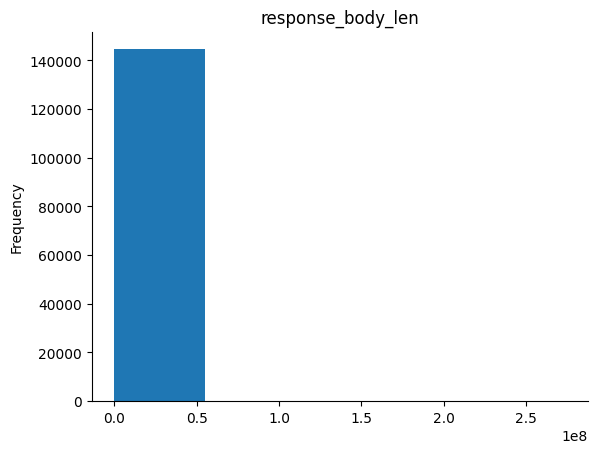

In [11]:
print(zeek_df['response_body_len'].describe())
zeek_df['response_body_len'].plot(kind='hist', bins=5, title='response_body_len')
plt.gca().spines[['top', 'right',]].set_visible(False)

The default response port is 80, and the second common one is 8080. HTTP data shouldn't be in other ports. The largest port number in network communication is 65535, but that shouldn't be a response port, so the 65534 port is definitely a strange thing.

count       144593.0
mean      968.212272
std      5624.362396
min             80.0
25%             80.0
50%             80.0
75%             80.0
max          65534.0
Name: id.resp_p, dtype: Float64


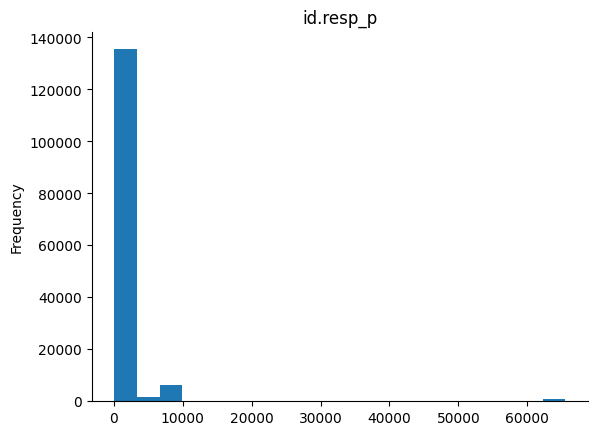

In [12]:
print(zeek_df['id.resp_p'].describe())
zeek_df['id.resp_p'].plot(kind='hist', bins=20, title='id.resp_p')
plt.gca().spines[['top', 'right',]].set_visible(False)

The numbers in the originator ports should be more than 1000—the ports that are used for response. We can see this behavior from the graph.

count        144593.0
mean     50700.502708
std      16196.923326
min            2439.0
25%           45123.0
50%           58765.0
75%           60182.0
max           65365.0
Name: id.orig_p, dtype: Float64


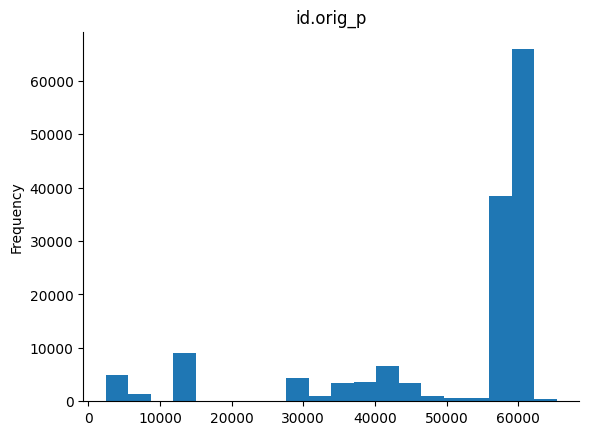

In [13]:
print(zeek_df['id.orig_p'].describe())
from matplotlib import pyplot as plt
zeek_df['id.orig_p'].plot(kind='hist', bins=20, title='id.orig_p')
plt.gca().spines[['top', 'right',]].set_visible(False)

We save our data frame to a Pickle file in my drive to save time each time I open my Colab notebook.

In [14]:
import pickle

# Define the path where you want to save the pickle file
save_path = "/content/drive/MyDrive/DTSA 5510/final project/Data/zeek_df.pkl"

# Open the file for writing in binary mode
with open(save_path, "wb") as f:
    # Use pickle.dump to serialize the dataframe and write it to the file
    pickle.dump(zeek_df, f)


Load the pickle to a data frame.

In [15]:
# Define the path where the pickle file is located
load_path = "/content/drive/MyDrive/DTSA 5510/final project/Data/zeek_df.pkl"

# Open the file for reading in binary mode
with open(load_path, "rb") as f:
    # Use pickle.load to deserialize the pickle file and load it into a dataframe
    zeek_df = pickle.load(f)

# Print the head of the dataframe
zeek_df.head()


,id.orig_p,id.resp_p,trans_depth,method,host,uri,referrer,version,user_agent,origin,...,tags,username,password,proxied,orig_fuids,orig_filenames,orig_mime_types,resp_fuids,resp_filenames,resp_mime_types
ts,,,,,,,,,,,,,,,,,,,,,
2018-03-24 17:15:20.609735936,36729,80,1,GET,10.47.3.200,/chassis/config/GeneralChassisConfig.html,NaN,1.1,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,NaN,...,(empty),NaN,NaN,NaN,NaN,NaN,NaN,FclSbzdCJ36qMN2C4,NaN,text/html
2018-03-24 17:15:20.611579904,39169,80,1,GET,10.47.3.200,/Webcam/webcam.html,NaN,1.1,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,NaN,...,(empty),NaN,NaN,NaN,NaN,NaN,NaN,FOLNVlDeSk9YPHaj7,NaN,text/html
2018-03-24 17:15:20.612331008,45517,8080,1,GET,10.47.27.80:8080,/test.cgi,NaN,1.1,() { _; } >_[$($())] { echo Content-Type: text...,NaN,...,(empty),NaN,NaN,NaN,NaN,NaN,NaN,Fq1QFX25xR138gOnfg,NaN,text/html
2018-03-24 17:15:20.616622080,37797,80,1,GET,10.47.3.200,/cgi-bin/camctrl.cgi,NaN,1.1,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,NaN,...,(empty),NaN,NaN,NaN,NaN,NaN,NaN,F6C4nv4kiCz6c3Dxbb,NaN,text/html
2018-03-24 17:15:20.625655808,37869,80,1,GET,10.47.3.200,/cgi-bin/ctrldirect.cgi,NaN,1.1,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,NaN,...,(empty),NaN,NaN,NaN,NaN,NaN,NaN,FhuCjV2nJgepcvHQyb,NaN,text/html


Senity check that everything looks the same.

In [16]:
zeek_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144593 entries, 2018-03-24 17:15:20.609735936 to 2018-03-24 17:33:31.862947072
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   id.orig_p          144593 non-null  UInt16  
 1   id.resp_p          144593 non-null  UInt16  
 2   trans_depth        144593 non-null  UInt64  
 3   method             143196 non-null  category
 4   host               141884 non-null  category
 5   uri                143196 non-null  category
 6   referrer           122345 non-null  category
 7   version            142240 non-null  category
 8   user_agent         142884 non-null  category
 9   origin             76 non-null      category
 10  request_body_len   144590 non-null  UInt64  
 11  response_body_len  144590 non-null  UInt64  
 12  status_code        142240 non-null  UInt64  
 13  status_msg         142240 non-null  category
 14  info_code          19 non-null

Data type munging:
all the data types look good. We don't have negative numbers with ports and lengths, so the Uint type is a good choice.
All the other columns except orig_fuids and resp_fuids, which represent file identification numbers, are category types that are memory efficient because they take a limited and fixed number of possible values, as suitable in our case.

Now, let's examine the numerical columns and see if we can find a correlation between them. This could help us reduce corolated columns.

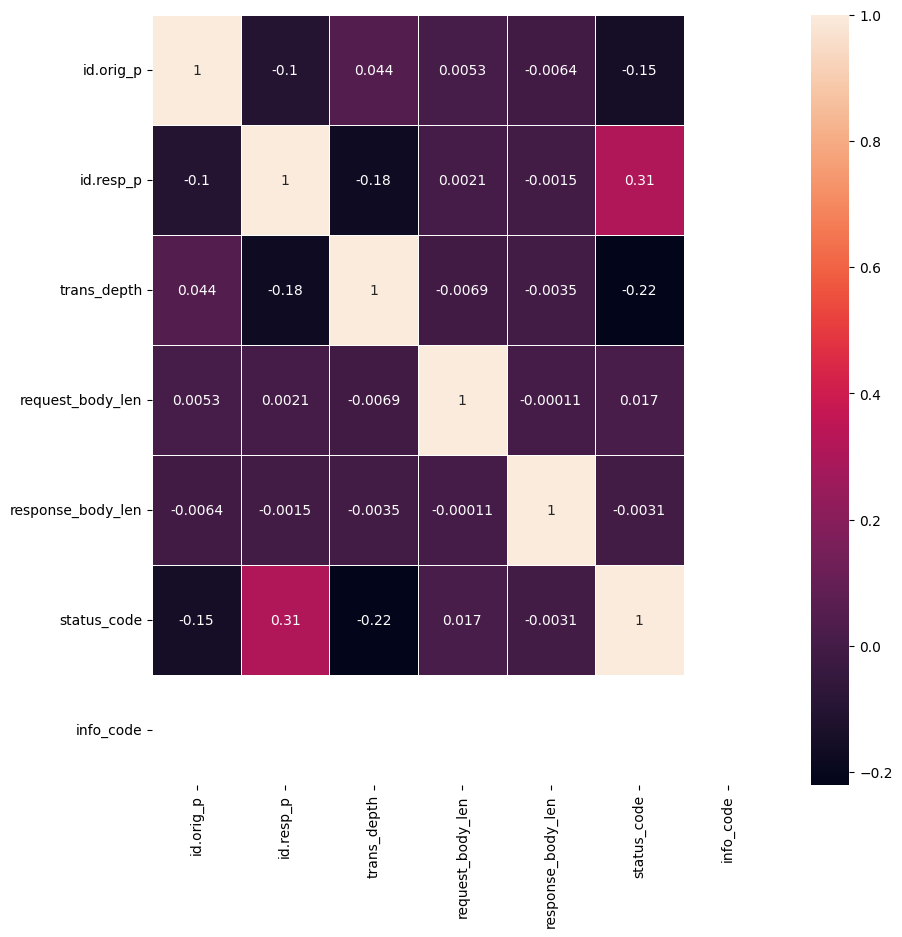

In [17]:
# Get the numerical columns
numerical_columns = zeek_df.select_dtypes(include=['UInt16', 'UInt64']).columns

# Create the correlation matrix
correlation_matrix = zeek_df[numerical_columns].corr()

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Generate the heatmap
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, ax=ax)

# Show the plot
plt.show()


No correlation was found. So, we can't remove columns because of correlated data. Let's continue to investigate.

We want to remove the columns with less than 10K values. These columns seem irrelevant because they don't exist for most of our data. The data we are dealing with is cyber security data protocol, so the lack of a field is not a potential anomaly or cyber attack—it's just a field that is not mandatory, and so it won't help us in our case.

In [18]:
# Find columns with less than 10000 non-null values
columns_to_drop = zeek_df.columns[zeek_df.isnull().sum() > (len(zeek_df) - 10000)]

# Drop the selected columns
zeek_df.drop(columns=columns_to_drop, inplace=True)

# Print the updated DataFrame
zeek_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144593 entries, 2018-03-24 17:15:20.609735936 to 2018-03-24 17:33:31.862947072
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   id.orig_p          144593 non-null  UInt16  
 1   id.resp_p          144593 non-null  UInt16  
 2   trans_depth        144593 non-null  UInt64  
 3   method             143196 non-null  category
 4   host               141884 non-null  category
 5   uri                143196 non-null  category
 6   referrer           122345 non-null  category
 7   version            142240 non-null  category
 8   user_agent         142884 non-null  category
 9   request_body_len   144590 non-null  UInt64  
 10  response_body_len  144590 non-null  UInt64  
 11  status_code        142240 non-null  UInt64  
 12  status_msg         142240 non-null  category
 13  tags               144590 non-null  category
 14  resp_fuids         139524 non-

This is the part where our knowledge of the topic will help us find new features that could help us find anomalies.
The first feature is the URI count—a small number of requests to a URI could potentially lead to a malicious URI.

In [19]:

uri_counts = zeek_df['uri'].value_counts()
zeek_df['uri_count'] = zeek_df['uri'].apply(lambda x: uri_counts[x])
zeek_df['uri_count']

ts
2018-03-24 17:15:20.609735936       8.0
2018-03-24 17:15:20.611579904       4.0
2018-03-24 17:15:20.612331008      42.0
2018-03-24 17:15:20.616622080       4.0
2018-03-24 17:15:20.625655808       4.0
                                  ...  
2018-03-24 17:31:30.717147136       1.0
2018-03-24 17:31:30.736620032       1.0
2018-03-24 17:36:30.008297984    6516.0
2018-03-24 17:36:27.226907904    6516.0
2018-03-24 17:33:31.862947072    6516.0
Name: uri_count, Length: 144593, dtype: float64

We also want to know how unique the referrer is. The referrer is the page that leads to our URI, and a small count could be interesting as the URI. No referrer at all could tell that a person typed the web site by hand, but it could also tell that it used some manipulations on the data.

In [20]:
referrer_counts = zeek_df['referrer'].value_counts()
zeek_df['referrer_count'] = zeek_df['referrer'].apply(lambda x: referrer_counts[x])
zeek_df['referrer_count'] = zeek_df['referrer_count'].fillna(0)
zeek_df['referrer_count']


ts
2018-03-24 17:15:20.609735936       0.0
2018-03-24 17:15:20.611579904       0.0
2018-03-24 17:15:20.612331008       0.0
2018-03-24 17:15:20.616622080       0.0
2018-03-24 17:15:20.625655808       0.0
                                  ...  
2018-03-24 17:31:30.717147136      20.0
2018-03-24 17:31:30.736620032       4.0
2018-03-24 17:36:30.008297984    9140.0
2018-03-24 17:36:27.226907904    9140.0
2018-03-24 17:33:31.862947072    9140.0
Name: referrer_count, Length: 144593, dtype: float64

We can see that most of the referrers have big values, but there are some with a small count—they are the interesting ones for anomaly detection.

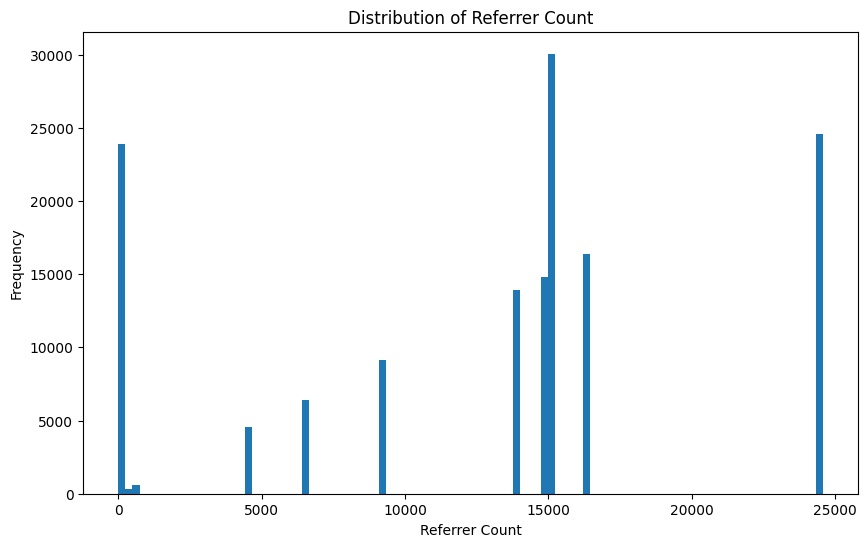

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(zeek_df['referrer_count'], bins=100)
plt.xlabel('Referrer Count')
plt.ylabel('Frequency')
plt.title('Distribution of Referrer Count')
plt.show()


The port itself is not intersting, but benign applications usually have small response ports; most ports are 80 or 8080 in HTTP. Let's check the small port and 80/8080 port.

In [22]:
# is small port in response and is 80 or 8080
zeek_df['resp_port_80_8080'] = zeek_df['id.resp_p'].apply(lambda x: 1 if x in [80, 8080] else 0)
zeek_df['is_small_port'] = (zeek_df['id.resp_p'] < 10000).astype(int)


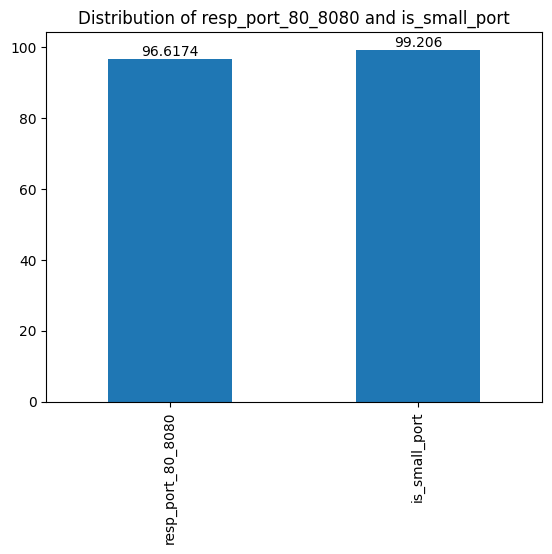

In [23]:
# Presentages of  The distribution of resp_port_80_8080 and the other is_small_port

# Calculate the percentages
percentages = zeek_df[['resp_port_80_8080', 'is_small_port']].mean() * 100

# Create a bar chart
ax = percentages.plot(kind='bar', title='Distribution of resp_port_80_8080 and is_small_port')

# Add labels
ax.bar_label(ax.containers[0])

# Show the plot
plt.show()


We can see that most of the data in response ports 80/8080 and 99% are small ports. So, a bigger port number is definitely an anomaly.


I want to know how many unique values every categorical column has.

In [24]:
categorical_columns = zeek_df.select_dtypes(include='category').columns
unique_values_count = {}
for column in categorical_columns:
  unique_values_count[column] = zeek_df[column].nunique()

# Print the dictionary containing the number of unique values for each categorical column
print(unique_values_count)


{'method': 55, 'host': 354, 'uri': 6444, 'referrer': 317, 'version': 3, 'user_agent': 138, 'status_msg': 25, 'tags': 2, 'resp_mime_types': 27}


Except for the URI and referrer columns, which don't hold data and could be replaced with the URI_count, all the other columns don't have too many different values and could be handled.

Let's take the features that could be valuable for our purpose of detecting anomalies.

In [25]:
features = ['id.resp_p', 'method', 'resp_mime_types', 'request_body_len','user_agent','status_msg', 'tags','status_code','referrer_count','uri_count', 'version','resp_port_80_8080', 'is_small_port']

The dataFrameToMatrix in the zat package handles numerical and categorical columns. It does this by one hot encoding technique. Categorical data is defined as variables with a finite set of label values, so the algorithm input is integers, not categorical data, which it can not handle.

In [26]:
# Use the zat DataframeToMatrix class (handles categorical data)
# You can see below it uses a heuristic to detect category data. When doing
# this for real we should explicitly convert before sending to the transformer.
to_matrix = DataFrameToMatrix()
zeek_matrix = to_matrix.fit_transform(zeek_df[features], normalize=True)
print(zeek_matrix.shape)
zeek_matrix[:1]

Normalizing column id.resp_p...
Normalizing column request_body_len...
Normalizing column status_code...
Normalizing column referrer_count...
Normalizing column uri_count...
Normalizing column resp_port_80_8080...
Normalizing column is_small_port...
(144593, 263)


array([[0.        , 0.        , 0.59840953, 0.        , 0.00107444,
        1.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

Now let's run our first algorithem- Isolation forest.

"**Isolation Forest** stands as a formidable anomaly detection algorithm renowned for its efficiency and versatility. Anomaly detection is the backbone of data analysis to identify patterns or events that deviate significantly from the norm in a dataset. Isolation forest operates by isolating anomalies within a dataset through a process of recursive partitioning.

Unlike traditional methods that rely on proximity measures, Isolation Forest takes a unique approach by randomly selecting features and splitting them along random values until individual data points are isolated.
This “isolating” process is responsible for creating partitions or “trees” that aim to separate anomalies from normal observations.
Anomalies, being fewer in number and further from the norm, typically require fewer splits to isolate, making them easier to detect.
By leveraging the concept of isolation, this algorithm efficiently distinguishes between normal and abnormal behavior, facilitating prompt action to mitigate potential risks or exploit valuable insights hidden within data anomalies."  geeksforgeeks.com

First, let's mark 25% of the data as an anomaly. We could change this later.

In [27]:
# Train/fit and Predict anomalous instances using the Isolation Forest model
odd_clf = IsolationForest(contamination=0.05) # Marking 10% odd
odd_clf.fit(zeek_matrix)

IsolationForest(contamination=0.05)

Great, let's investigate the rows the algorithm spotted as anomalies.

In [28]:
# Now we create a new dataframe using the prediction from our classifier
odd_df = zeek_df[features][odd_clf.predict(zeek_matrix) == -1]
print(odd_df.shape)
odd_df.head()

(7082, 13)


,id.resp_p,method,resp_mime_types,request_body_len,user_agent,status_msg,tags,status_code,referrer_count,uri_count,version,resp_port_80_8080,is_small_port
ts,,,,,,,,,,,,,
2018-03-24 17:15:20.724855808,65534,GET,text/plain,0,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,OK,(empty),200,0.0,6175.0,1.1,0,0
2018-03-24 17:15:20.742312960,8080,PUT,text/html,16,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,Not Found,(empty),404,0.0,3.0,1.1,1,1
2018-03-24 17:15:20.742845952,65534,GET,text/plain,0,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,Not Found,(empty),404,0.0,9.0,1.1,0,0
2018-03-24 17:15:20.962438144,5800,GET,text/html,0,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,Not Found,(empty),404,0.0,1.0,1.0,0,1
2018-03-24 17:15:21.743621120,5800,GET,text/html,0,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,Not Found,(empty),404,0.0,1.0,1.0,0,1


We can see strange things in the spotted rows, but let's remember that they represent 5% of our data. Let's try to cluster the anomalies so it would be easier for us to investigate the data.

In [29]:
# Now we're going to explore our odd dataframe with help from KMeans and PCA algorithms
odd_matrix = to_matrix.fit_transform(odd_df)

Normalizing column id.resp_p...
Normalizing column request_body_len...
Normalizing column status_code...
Normalizing column referrer_count...
Normalizing column uri_count...
Normalizing column resp_port_80_8080...
Normalizing column is_small_port...


So, we want to cluster our anomaly data and plot to see the differences and fitting of our anomalies. We use two algorithm - first we use **K-Means** with 4 clusters (why 3? We will get to it later)


"k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster." wikipedia



In [30]:
kmeans = KMeans(n_clusters=4, n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=11, algorithm='lloyd').fit_predict(odd_matrix)

Next, we use the PCA algorithm we learned in class to reduce the dimensionality of our data. The last step is to merge the two steps—adding a cluster to the dimensionality reduces the data of the anomalies.

"Principal component analysis (PCA) is a linear dimensionality reduction technique with applications in exploratory data analysis, visualization and data preprocessing.

The data is linearly transformed onto a new coordinate system such that the directions (principal components) capturing the largest variation in the data can be easily identified." wikipedia

In [31]:

pca = PCA(n_components=3).fit_transform(odd_matrix)

# Now we can put our ML results back onto our dataframe.
odd_df['x'] = pca[:, 0] # PCA X Column
odd_df['y'] = pca[:, 1] # PCA Y Column
odd_df['cluster'] = kmeans
odd_df.head()

,id.resp_p,method,resp_mime_types,request_body_len,user_agent,status_msg,tags,status_code,referrer_count,uri_count,version,resp_port_80_8080,is_small_port,x,y,cluster
ts,,,,,,,,,,,,,,,,
2018-03-24 17:15:20.724855808,65534,GET,text/plain,0,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,OK,(empty),200,0.0,6175.0,1.1,0,0,-331.279266,-26.712894,0
2018-03-24 17:15:20.742312960,8080,PUT,text/html,16,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,Not Found,(empty),404,0.0,3.0,1.1,1,1,-331.709839,-25.775059,0
2018-03-24 17:15:20.742845952,65534,GET,text/plain,0,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,Not Found,(empty),404,0.0,9.0,1.1,0,0,-331.710205,-25.777487,0
2018-03-24 17:15:20.962438144,5800,GET,text/html,0,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,Not Found,(empty),404,0.0,1.0,1.0,0,1,-331.709412,-25.776304,0
2018-03-24 17:15:21.743621120,5800,GET,text/html,0,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,Not Found,(empty),404,0.0,1.0,1.0,0,1,-331.709412,-25.776304,0


In [32]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14.0
plt.rcParams['figure.figsize'] = 15.0, 6.0

# Helper method for scatter/beeswarm plot
def jitter(arr):
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

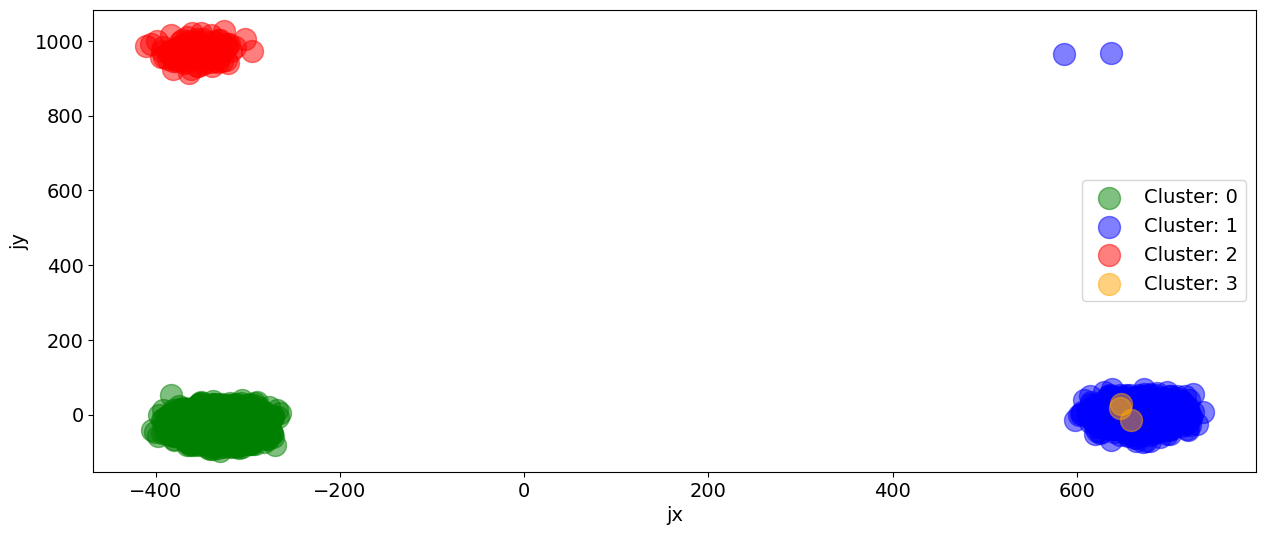

In [33]:
# Jitter so we can see instances that are projected coincident in 2D
odd_df['jx'] = jitter(odd_df['x'])
odd_df['jy'] = jitter(odd_df['y'])

# Now use dataframe group by cluster
cluster_groups = odd_df.groupby('cluster')

# Plot the Machine Learning results
colors = {0:'green', 1:'blue', 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])

We can see two big clusters that are very far from each other, two clusters—one big one and another small one—that are not far from each other, and two clusters—one big one and another small one—that intersect one another.

lets look at the examples from each cluster.

In [34]:
# Now print out the details for each cluster
pd.set_option('display.width', 1000)
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[features].head())


Cluster 0: 4609 observations
                               id.resp_p method resp_mime_types  request_body_len                                         user_agent status_msg     tags  status_code  referrer_count  uri_count version  resp_port_80_8080  is_small_port
ts                                                                                                                                                                                                                                        
2018-03-24 17:15:20.724855808      65534    GET      text/plain                 0  Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...         OK  (empty)          200             0.0     6175.0     1.1                  0              0
2018-03-24 17:15:20.742312960       8080    PUT       text/html                16  Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...  Not Found  (empty)          404             0.0        3.0     1.1                  1              1
2018-03-24 17:15:20.742845952 

One thing we noticed is the request body length. It seems to be 0 for all the rows.
It's the same for all the dataset so that not an outlier.


For this dataset almost all request_body_len are 0
Cluster 2 represents outliers


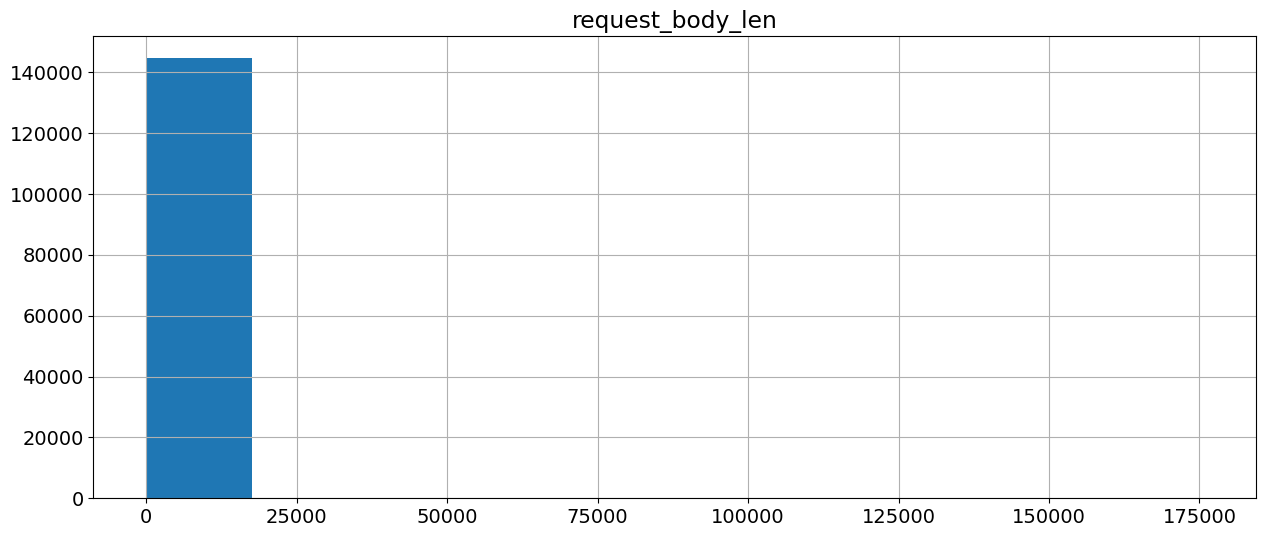

In [35]:
# Distribution of the request body length
zeek_df[['request_body_len']].hist()
print('\nFor this dataset almost all request_body_len are 0\nCluster 2 represents outliers')

So we can see the outliers and even understand **why** they are outliers, but what about the plot? How can we tell if the number of clusters is optimal for our mission? That is where Silhouette analysis comes to rescue.

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Let's plot our results and see how many clusters are optimal from 2 to 16 clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

<Axes: xlabel='Num Clusters'>

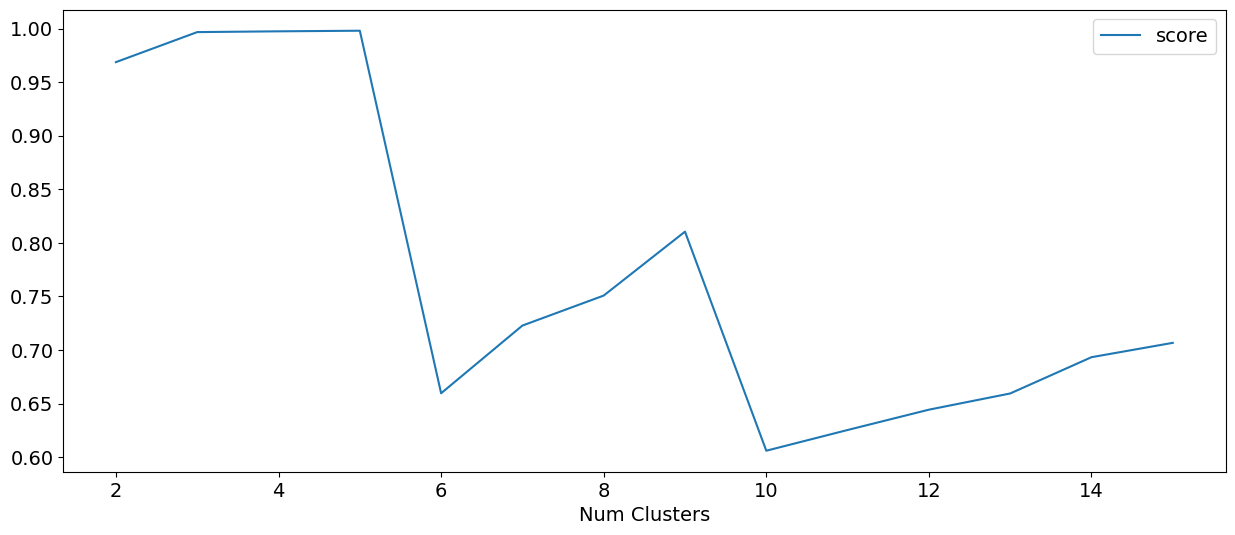

In [36]:

from sklearn.metrics import silhouette_score

scores = []
clusters = range(2,16)
for K in clusters:

    clusterer = KMeans(n_clusters=K)
    cluster_labels = clusterer.fit_predict(odd_matrix)
    score = silhouette_score(odd_matrix, cluster_labels)
    scores.append(score)

# Plot it out
pd.DataFrame({'Num Clusters':clusters, 'score':scores}).plot(x='Num Clusters', y='score')

We can see that 3-5 was given as the best score. We prefer five because it splits our data into more parts, making it easier for us to investigate.

We use Kmeans again but this time insted of using PCA we will use TSNE - s an unsupervised non-linear dimensionality reduction technique for data exploration and visualizing high-dimensional data.

In [37]:
# So we know that the highest (closest to 1) silhouette score is at 5 clusters
kmeans = KMeans(n_clusters=5).fit_predict(odd_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [38]:
odd_df.head()

,id.resp_p,method,resp_mime_types,request_body_len,user_agent,status_msg,tags,status_code,referrer_count,uri_count,version,resp_port_80_8080,is_small_port,x,y,cluster,jx,jy
ts,,,,,,,,,,,,,,,,,,
2018-03-24 17:15:20.724855808,65534,GET,text/plain,0,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,OK,(empty),200,0.0,6175.0,1.1,0,0,-331.279266,-26.712894,0,-300.813482,10.808726
2018-03-24 17:15:20.742312960,8080,PUT,text/html,16,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,Not Found,(empty),404,0.0,3.0,1.1,1,1,-331.709839,-25.775059,0,-310.788613,13.274510
2018-03-24 17:15:20.742845952,65534,GET,text/plain,0,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,Not Found,(empty),404,0.0,9.0,1.1,0,0,-331.710205,-25.777487,0,-312.984890,-70.578725
2018-03-24 17:15:20.962438144,5800,GET,text/html,0,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,Not Found,(empty),404,0.0,1.0,1.0,0,1,-331.709412,-25.776304,0,-313.331756,-27.152423
2018-03-24 17:15:21.743621120,5800,GET,text/html,0,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,Not Found,(empty),404,0.0,1.0,1.0,0,1,-331.709412,-25.776304,0,-320.263183,-46.183027


In [39]:


# In this case we're going from 12 dimensions to 2
projection = TSNE().fit_transform(odd_matrix)
# Now we can put our ML results back onto our dataframe!
odd_df['cluster2'] = kmeans
odd_df['x2'] = projection[:, 0] # Projection X Column
odd_df['y2'] = projection[:, 1] # Projection Y Column

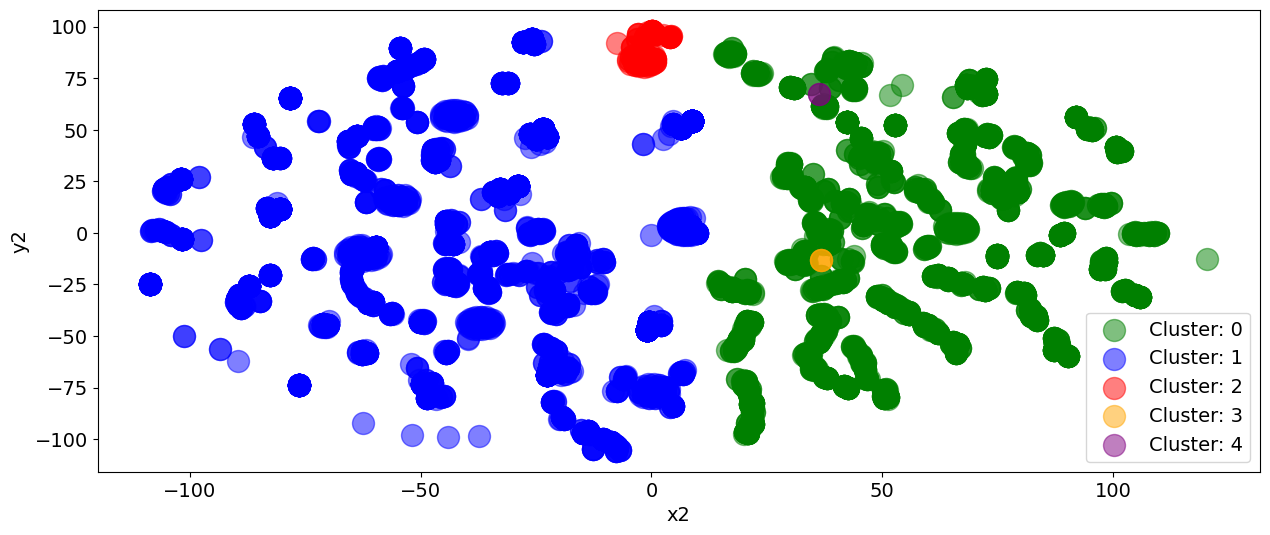

In [40]:
# Now use dataframe group by cluster
cluster_groups = odd_df.groupby('cluster2')

# Plot the Machine Learning results
colors = {0:'green', 1:'blue', 2:'red', 3:'orange', 4:'purple'}
fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='x2', y='y2', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])

In [41]:
# Now print out the details for each cluster
pd.set_option('display.width', 1000)
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[features].head(3))


Cluster 0: 2348 observations
                               id.resp_p method resp_mime_types  request_body_len                                         user_agent status_msg     tags  status_code  referrer_count  uri_count version  resp_port_80_8080  is_small_port
ts                                                                                                                                                                                                                                        
2018-03-24 17:15:21.170690048         80    PRI             NaN                 0                                                NaN        NaN  (empty)         <NA>             0.0       39.0     NaN                  1              1
2018-03-24 17:15:22.119563008        808    GET             NaN                 0  Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...        NaN  (empty)         <NA>             0.0     6175.0     NaN                  0              1
2018-03-24 17:15:23.127016192 

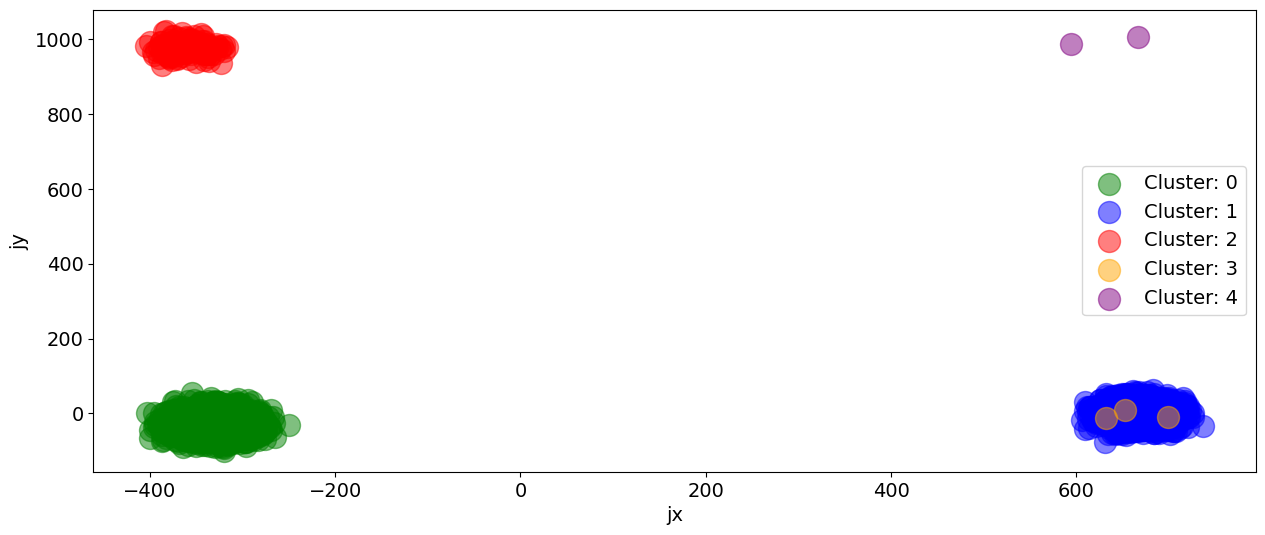

In [42]:
kmeans = KMeans(n_clusters=5, n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=11, algorithm='lloyd').fit_predict(odd_matrix)
pca = PCA(n_components=3).fit_transform(odd_matrix)

# Now we can put our ML results back onto our dataframe.
odd_df['x'] = pca[:, 0] # PCA X Column
odd_df['y'] = pca[:, 1] # PCA Y Column
odd_df['cluster'] = kmeans

# Jitter so we can see instances that are projected coincident in 2D
odd_df['jx'] = jitter(odd_df['x'])
odd_df['jy'] = jitter(odd_df['y'])

# Now use dataframe group by cluster
cluster_groups = odd_df.groupby('cluster')

# Plot the Machine Learning results
colors = {0:'green', 1:'blue', 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])

In [43]:

# Now print out the details for each cluster
pd.set_option('display.width', 1000)
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[features].head())


Cluster 0: 4609 observations
                               id.resp_p method resp_mime_types  request_body_len                                         user_agent status_msg     tags  status_code  referrer_count  uri_count version  resp_port_80_8080  is_small_port
ts                                                                                                                                                                                                                                        
2018-03-24 17:15:20.724855808      65534    GET      text/plain                 0  Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...         OK  (empty)          200             0.0     6175.0     1.1                  0              0
2018-03-24 17:15:20.742312960       8080    PUT       text/html                16  Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...  Not Found  (empty)          404             0.0        3.0     1.1                  1              1
2018-03-24 17:15:20.742845952 

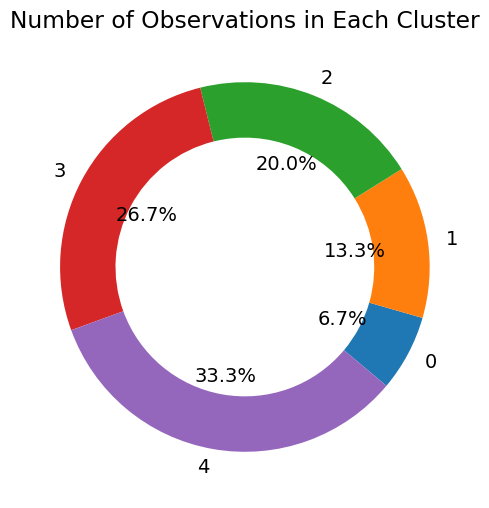

In [46]:
# Define data
cluster_counts = {
    0: 10,
    1: 20,
    2: 30,
    3: 40,
    4: 50,
}

# Prepare data for visualization
labels = list(cluster_counts.keys())
values = list(cluster_counts.values())

# Create pie chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(values, labels=labels, autopct="%1.1f%%", startangle=-40, wedgeprops=dict(width=0.3))

# Add title and show plot
ax.set_title("Number of Observations in Each Cluster")
plt.show()


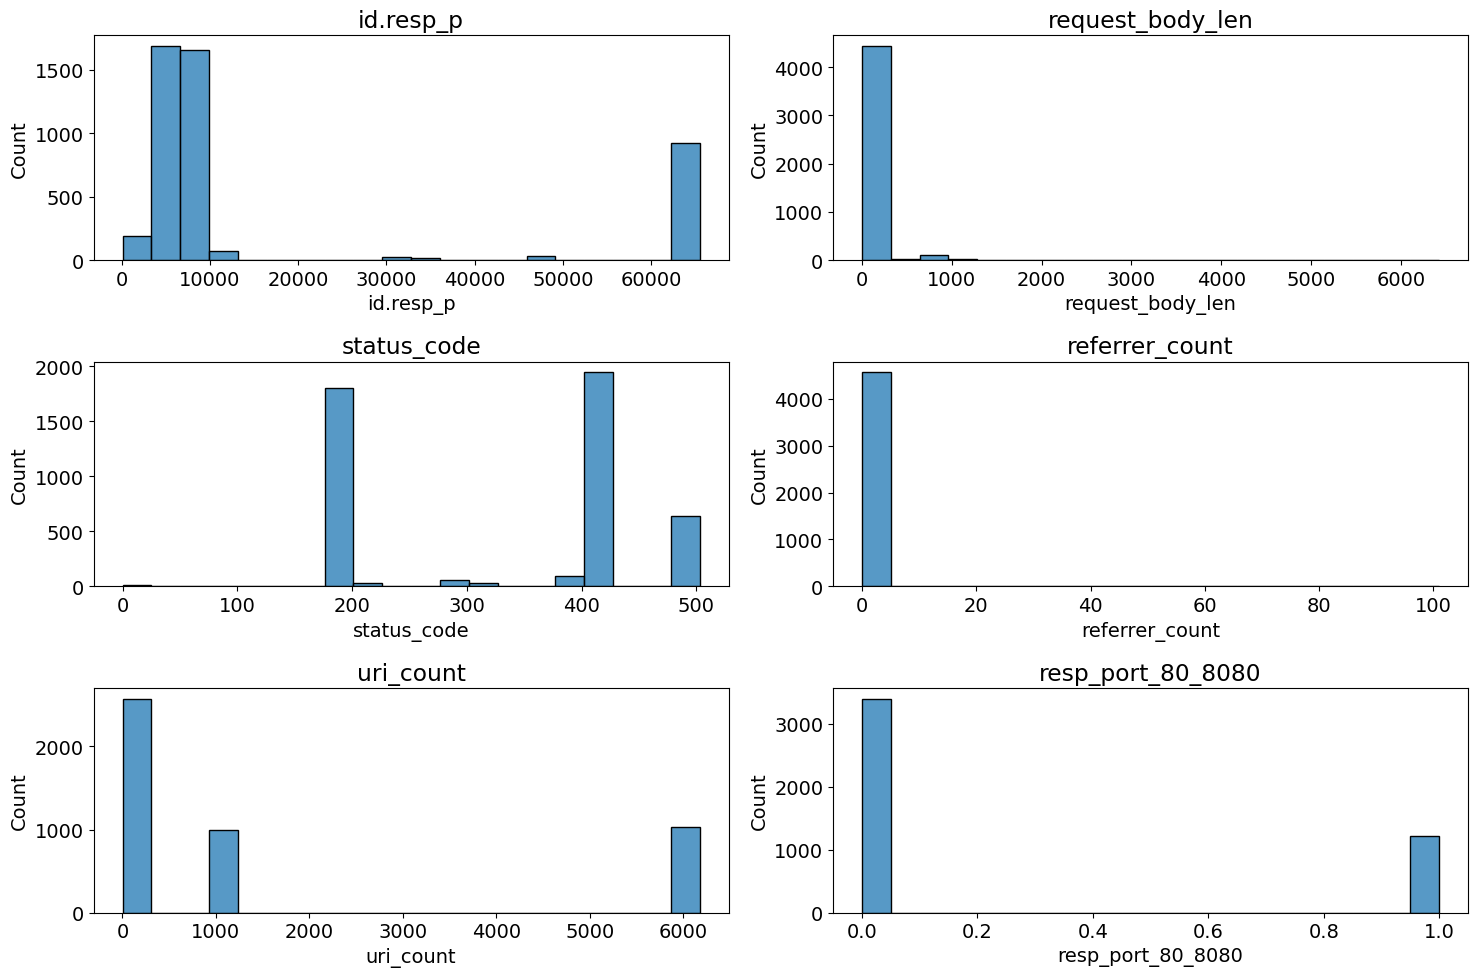

In [51]:
# Define the cluster number
cluster_num = 0

# Filter the DataFrame for cluster 0
cluster_0_df = odd_df[odd_df['cluster'] == cluster_num]

# Create a figure with subplots for each numerical feature
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

# Plot the distribution of each numerical feature
sns.histplot(data=cluster_0_df, x="id.resp_p", bins=20, ax=axes[0, 0])
sns.histplot(data=cluster_0_df, x="request_body_len", bins=20, ax=axes[0, 1])
sns.histplot(data=cluster_0_df, x="status_code", bins=20, ax=axes[1, 0])
sns.histplot(data=cluster_0_df, x="referrer_count", bins=20, ax=axes[1, 1])
sns.histplot(data=cluster_0_df, x="uri_count", bins=20, ax=axes[2, 0])
sns.histplot(data=cluster_0_df, x="resp_port_80_8080", bins=20, ax=axes[2, 1])

# Set the titles for each subplot
axes[0, 0].set_title("id.resp_p")
axes[0, 1].set_title("request_body_len")
axes[1, 0].set_title("status_code")
axes[1, 1].set_title("referrer_count")
axes[2, 0].set_title("uri_count")
axes[2, 1].set_title("resp_port_80_8080")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# Discussion and Conclusion

We can see that anomaly data that we Split into five categories is relatively straightforward for investigation.

**Cluster 4** contains data with no fields except request_body_len, a phenomenon that does not exist in real HTTP data.

**Cluster 3** is even worse - we have URIs (uri_count is not zero) and method fields, but all the other fields are zeros, including zero request_body_len.

**Cluster 2** contains no user_agent ( there must be a user_agent in HTTP data), no refer page, no method, and no status code.

**Claster 1** have no status_code, zero reffere_count and zero request_body_len.

**Claster 0** which is the biggest of all is the most intersting - we have mix Values in different columns cause anomalies, such as big port numbers, no body length, or strange status codes and methods.


So the mix of the algorithms - Isolation Forest+ K menas + PCA gave us good results for clusters 1-4; it's very easy to see what makes them anomalies and start an investigation in the organization of the HTTP data - what is the IP that made the connection? Is this IP benign? If not, block it. If the answer is yes, the next step would be to see if some malicious software was installed on this PC or phone. We could also investigate if this IP makes connections with different user agents, which can be a spoofing process.

# Discussion and Conclusion

We aim to find anomaly HTTP sessions in our recorded ZEEK IDS log files.
First, we investigated and found the relevant log features in our data. Then, we created new features that could be relevant to our task.
The model's first step was the isolation forest algorithm, which can find anomalies in the given data. The problem with this algorithm is that it doesn't explain why a row is considered an anomaly. So our next steps were to group all the anomaly data into clusters to understand what makes them an anomaly. We used the K means algorithm with PCA to group the data and Silhouette Score to find the perfect number of clusters. We tried the T-SNE algorithm as an alternative to PCA to reduce the Dimensionality of the data, but PCA gave us better results.
Most of the clusters gave clear results, and it was easy to understand what makes them anomalies. Cluster 0 results were more challenging to tell because the reason for them being anomalies is the nonlinear connection between features.
Some ways to improve the results could be making more features, maybe even parsing existing features to their contents. Another way could be taking only cluster zero and trying to investigate it with anomaly detection algorithms on its own. It could lead to interesting results.



## Thanks for reading!